# Halo experimentation
# 6/27/24

In [1]:
import matplotlib as mpl
mpl.use('Agg')
from matplotlib import pyplot as plt
import yt
yt.enable_parallelism()
import numpy as np
from yt.frontends.gizmo.api import GizmoDataset
import sys
from scipy.signal import gaussian
from scipy.ndimage import filters
import os
import cmocean
from radial_profile1 import find_center_iteratively
from astropy.io import fits, ascii
from astropy.table import Table

yt : [ERROR    ] 2024-07-02 11:34:07,174 Could not enable parallelism: only one mpi process is running. To remedy this, launch the Python interpreter as
  mpirun -n <X> python3 <yourscript>.py  # with X > 1 
[dhcp-194-236.caltech.edu:45245] shmem: mmap: an error occurred while determining whether or not /var/folders/7q/qfsy4gkn1v94_r366nrxc3kw0000gn/T//ompi.dhcp-194-236.501/jf.0/2478178304/sm_segment.dhcp-194-236.501.93b60000.0 could be created.


In [2]:
fn = "../runs/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5"
# fn = "../runs/m12i_res450000/output/snapshot_570.hdf5"

ds = GizmoDataset(fn)

yt : [INFO     ] 2024-07-02 11:34:20,312 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2024-07-02 11:34:20,314 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2024-07-02 11:34:20,438 Parameters: current_time              = 4.3545571088051405e+17 s
yt : [INFO     ] 2024-07-02 11:34:20,440 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-02 11:34:20,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-02 11:34:20,445 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2024-07-02 11:34:20,446 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-07-02 11:34:20,446 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-07-02 11:34:20,447 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2024-07-02 11:34:20,448 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2024-07-02 11:34:20,449 Parameters: omega_radiation           = 0.

In [3]:
print(ds.particle_type_counts)

yt : [INFO     ] 2024-07-02 11:34:25,107 Allocating for 1.471e+08 particles
Initializing coarse index : 100%|█████████████| 272/272 [00:47<00:00,  5.76it/s]
yt : [INFO     ] 2024-07-02 11:35:13,063 Updating index_order2 from 2 to 2
Initializing refined index: 100%|█████████████| 272/272 [01:11<00:00,  3.82it/s]


{'PartType0': 57060074, 'PartType1': 70514272, 'PartType2': 5513331, 'PartType3': 0, 'PartType4': 13976485, 'PartType5': 0}


In [4]:
c = find_center_iteratively(fn, ds=ds)
#c = read_amiga_center(amiga_data, fn, ds)
#_, c = ds.find_max('density')
rvir = ds.quan(30, 'kpc')
sp = ds.sphere(c, rvir)
bulk_vel = sp.quantities.bulk_velocity()
#print("Bulk Velocity of Halo = %s" % bulk_vel.to('km/s'))
sp.set_field_parameter("bulk_velocity", bulk_vel)

Pass 0: 3829217 particles
   radius = 23416.179352
Pass 1: 3829216 particles
   radius = 20982.004654
Pass 2: 3829215 particles
   radius = 10420.749491
Pass 3: 3829214 particles
   radius = 8103.649633
Pass 4: 3829212 particles
   radius = 6972.609321
Pass 5: 3829210 particles
   radius = 6091.232980
Pass 6: 3829195 particles
   radius = 5345.404468
Pass 7: 3829182 particles
   radius = 4810.552960
Pass 8: 3829172 particles
   radius = 4324.317203
Pass 9: 3829165 particles
   radius = 3880.121683
Pass 10: 3829135 particles
   radius = 3461.944946
Pass 11: 3829110 particles
   radius = 3103.331672
Pass 12: 3829010 particles
   radius = 2784.294051
Pass 13: 3828908 particles
   radius = 2504.245066
Pass 14: 3828718 particles
   radius = 2252.371499
Pass 15: 3827825 particles
   radius = 2027.494649
Pass 16: 3743076 particles
   radius = 1837.078587
Pass 17: 3742308 particles
   radius = 1651.227743
Pass 18: 3577472 particles
   radius = 1549.599838
Pass 19: 3539986 particles
   radius =

In [5]:
ax = [0,1,0]

In [6]:
ad = ds.all_data()
ad.set_field_parameter('center', c)
ad.set_field_parameter('bulk_velocity', bulk_vel)
ad.set_field_parameter('normal', np.array(ax))

In [7]:
# using smoothing length as an analog for the size of the gas region
def _H_I_number(field, data):
    return data[('gas', 'H_p0_number_density')] * (4./3. * 3.14 * data[('gas', 'smoothing_length')]**1)

# This is to correct a problem in the tip of yt-4 that messes up the units
# of cylindrical radius to be a factor of kpc/cm too low
# def _cylindrical_radius_kpc(field, data):
#     return data[('gas', 'cylindrical_radius')] / (3e21)

ds.add_field(("gas","H_I_column_density"), function=_H_I_number, units="cm**(-2)", sampling_type='particle')
# ds.add_field(("PartType0","cylindrical_radius_kpc"), function=_cylindrical_radius_kpc, units="cm", sampling_type='particle')


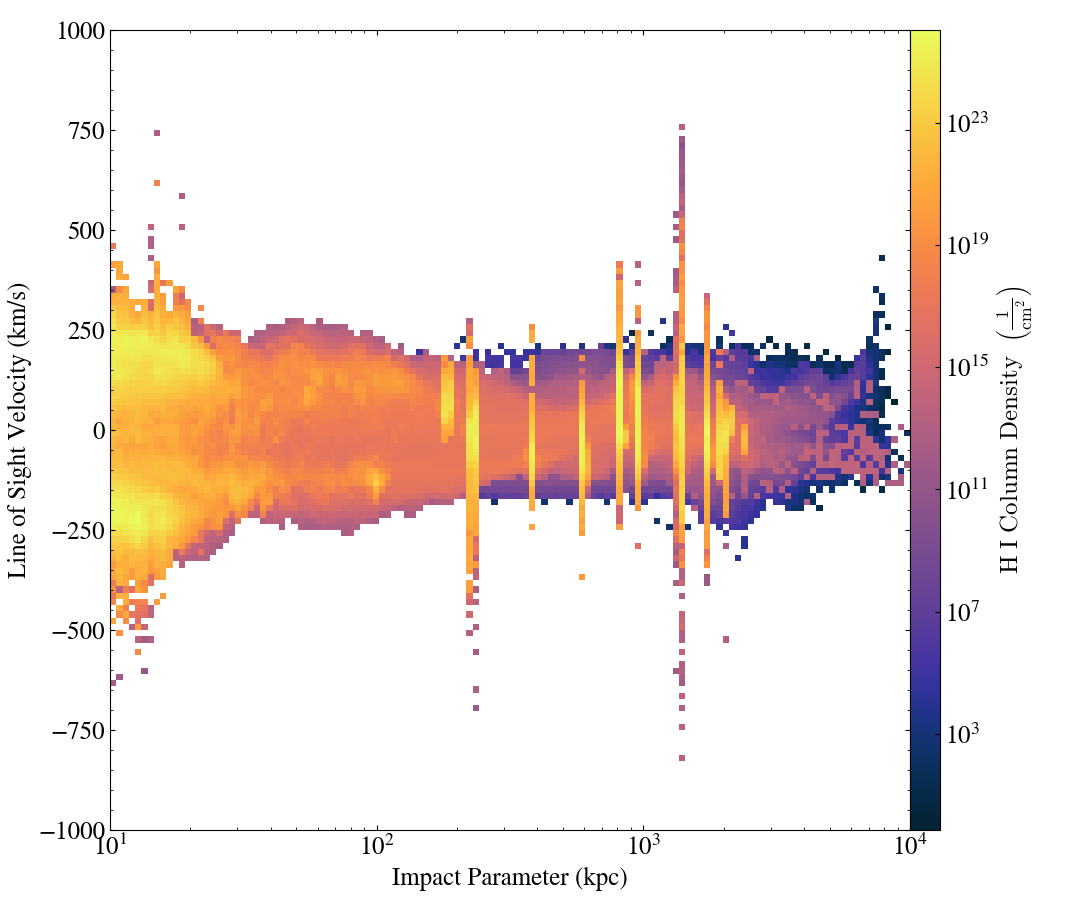

In [8]:
p = yt.PhasePlot(ad, ('gas', 'cylindrical_radius'), ('gas', 'velocity_cylindrical_z'), ("gas","H_I_column_density"), weight_field=None)
p.set_unit(('gas', 'cylindrical_radius'), 'kpc')
p.set_unit(('gas', 'velocity_cylindrical_z'), 'km/s')
p.set_log(('gas', 'velocity_cylindrical_z'), False)
p.set_xlim(1e1, 1e4)
p.set_ylim(-1000,1000)
p.set_cmap(('gas', 'H_I_column_density'), cmocean.cm.thermal)
#p.set_zlim(('gas', 'H_I_number'), 1e12, 1e25)
p.set_xlabel('Impact Parameter (kpc)')
p.set_ylabel('Line of Sight Velocity (km/s)')
p.show()

# Try different angles

yt : [INFO     ] 2024-06-27 15:58:52,561 xlim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:58:52,562 ylim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:58:52,563 xlim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:58:52,563 ylim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:58:52,569 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



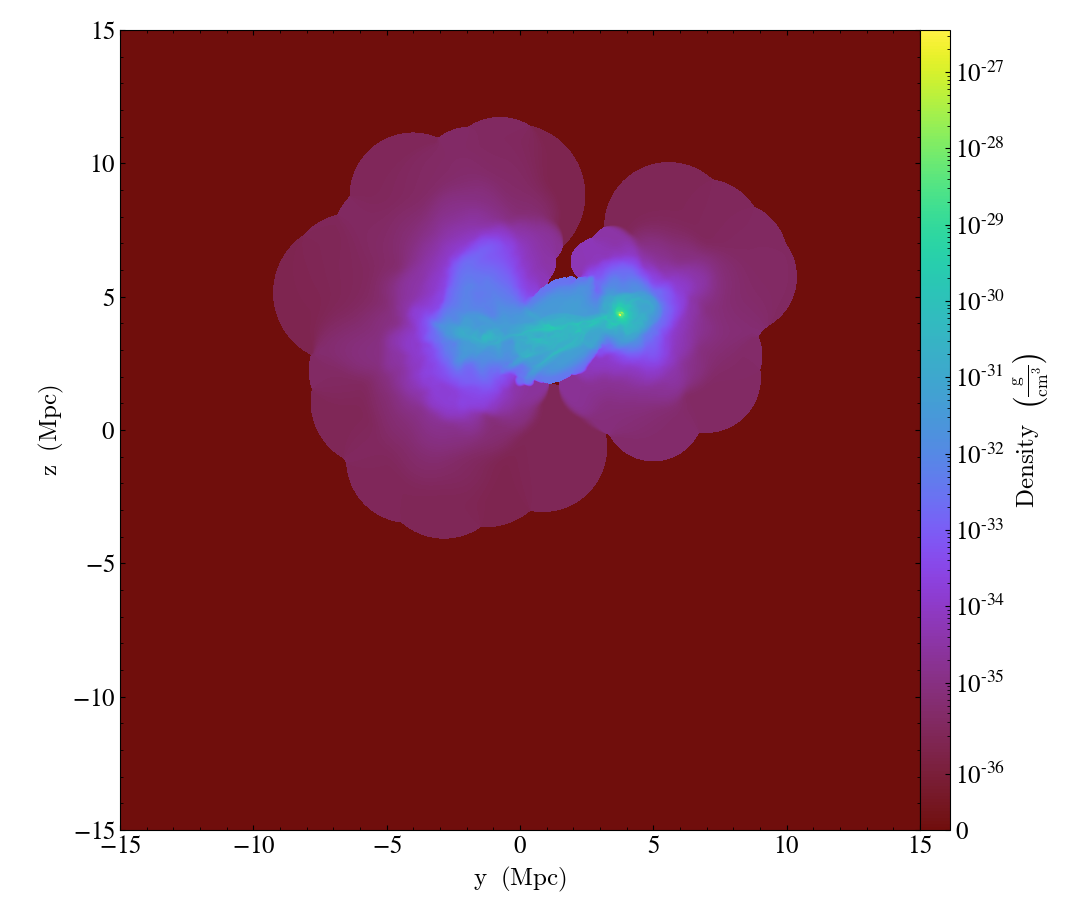

yt : [INFO     ] 2024-06-27 15:59:08,566 xlim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:08,566 ylim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:08,568 xlim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:08,569 ylim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:08,574 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



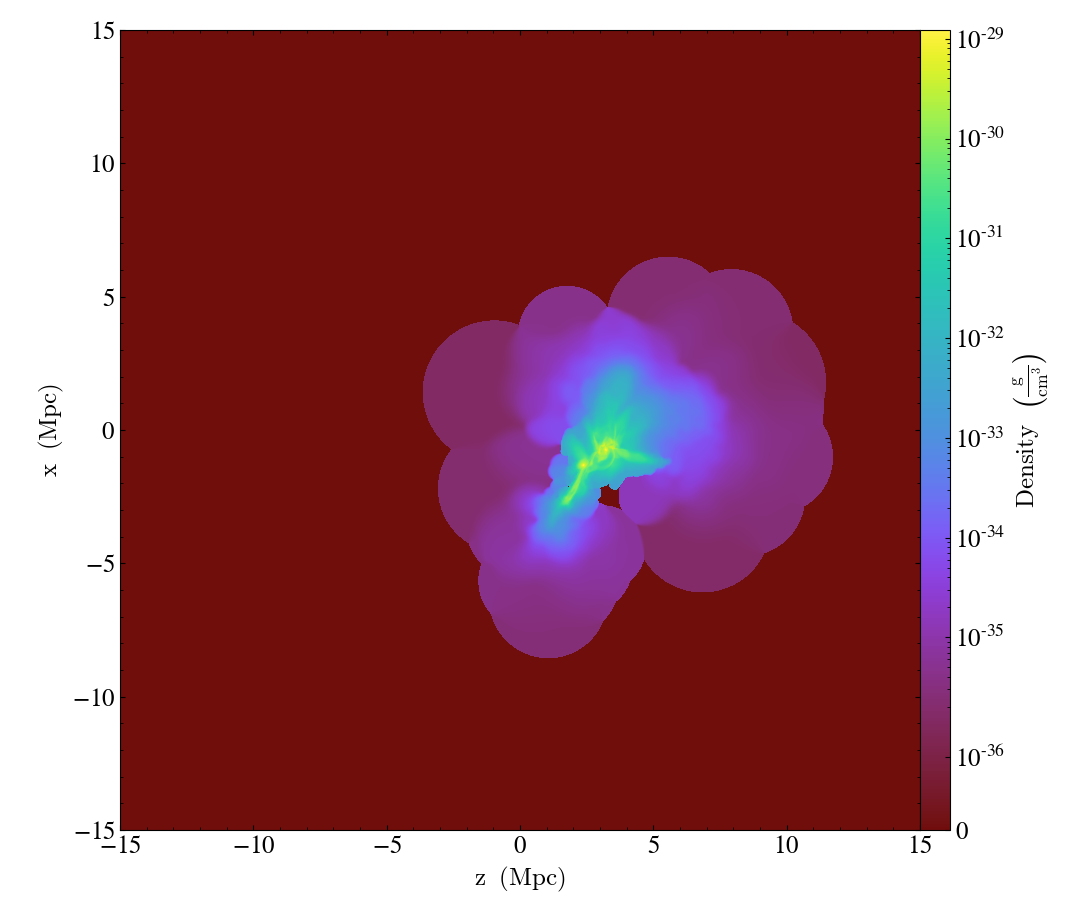

yt : [INFO     ] 2024-06-27 15:59:22,561 xlim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:22,562 ylim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:22,563 xlim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:22,563 ylim = 19105.700038 40894.299962
yt : [INFO     ] 2024-06-27 15:59:22,568 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



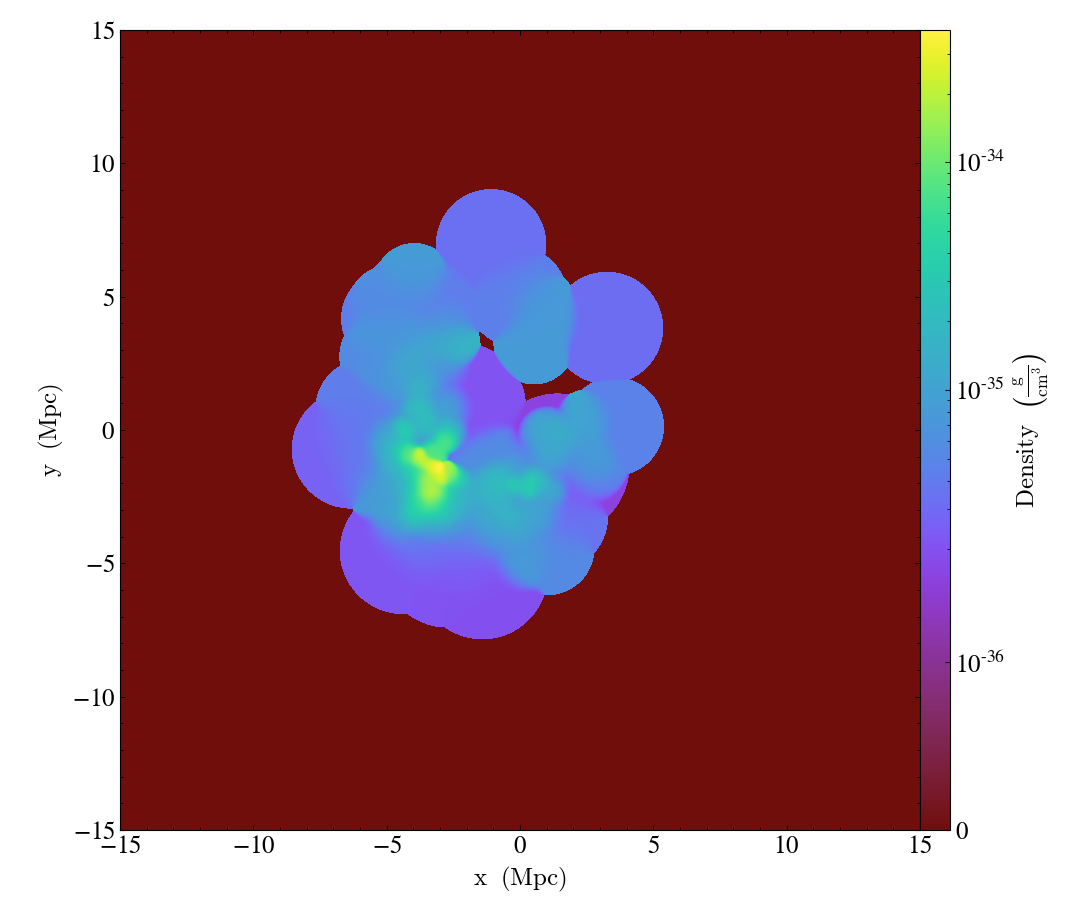

In [55]:
yt.SlicePlot(ds, "x", ("gas", "density"), width=(30.0, "Mpc")).show()
yt.SlicePlot(ds, "y", ("gas", "density"), width=(30.0, "Mpc")).show()
yt.SlicePlot(ds, "z", ("gas", "density"), width=(30.0, "Mpc")).show()


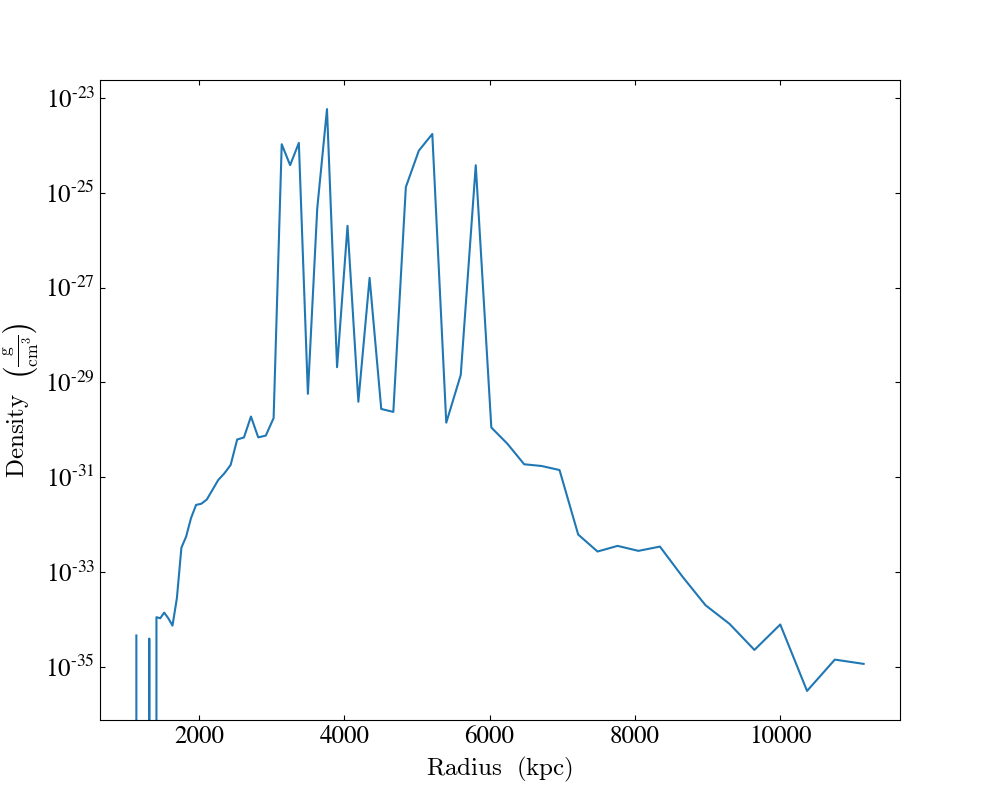

In [56]:
# Create a sphere of radius 100 kpc in the center of the box.
my_sphere = ds.sphere("c", (30.0, "Mpc"))

# Create a profile of the average density vs. radius.
plot = yt.ProfilePlot(
    my_sphere,
    ("gas", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
)

# Change the units of the radius into kpc (and not the default in cgs)
plot.set_unit(("gas", "radius"), "kpc")
plot.set_log(('gas', 'radius'), False)

# Save the image.
# Optionally, give a string as an argument
# to name files with a keyword.
plot.show()

In [4]:
c = find_center_iteratively(fn, ds=ds)
rvir = ds.quan(30, 'kpc')
sp = ds.sphere(c, rvir)
bulk_vel = sp.quantities.bulk_velocity()
L = sp.quantities.angular_momentum_vector()

Pass 0: 3021796 particles
   radius = 15238.767279
Pass 1: 3021795 particles
   radius = 13137.311216
Pass 2: 3021794 particles
   radius = 10676.727905
Pass 3: 3021792 particles
   radius = 5405.255879
Pass 4: 3021788 particles
   radius = 4815.371615
Pass 5: 3021784 particles
   radius = 4050.641356
Pass 6: 3021777 particles
   radius = 3588.075418
Pass 7: 3021770 particles
   radius = 3188.598380
Pass 8: 3021756 particles
   radius = 2834.159281
Pass 9: 3021732 particles
   radius = 2548.435051
Pass 10: 3021679 particles
   radius = 2289.968262
Pass 11: 3021541 particles
   radius = 2060.629449
Pass 12: 2912893 particles
   radius = 1907.037219
Pass 13: 2912736 particles
   radius = 1713.436981
Pass 14: 2868061 particles
   radius = 1562.627698
Pass 15: 2810305 particles
   radius = 1429.492709
Pass 16: 2797968 particles
   radius = 1288.951575
Pass 17: 2797908 particles
   radius = 1158.744420
Pass 18: 2747109 particles
   radius = 1050.270912
Pass 19: 2747076 particles
   radius =

In [47]:
print(L)
Lnorm = L/np.sqrt(np.sum(L**2))
# print(f"{Lnorm:.2e}")
ax = [0.3, 0.4, 0.5]

[-4.16194860e+28  6.39659683e+28 -5.58049869e+28] cm**2/s



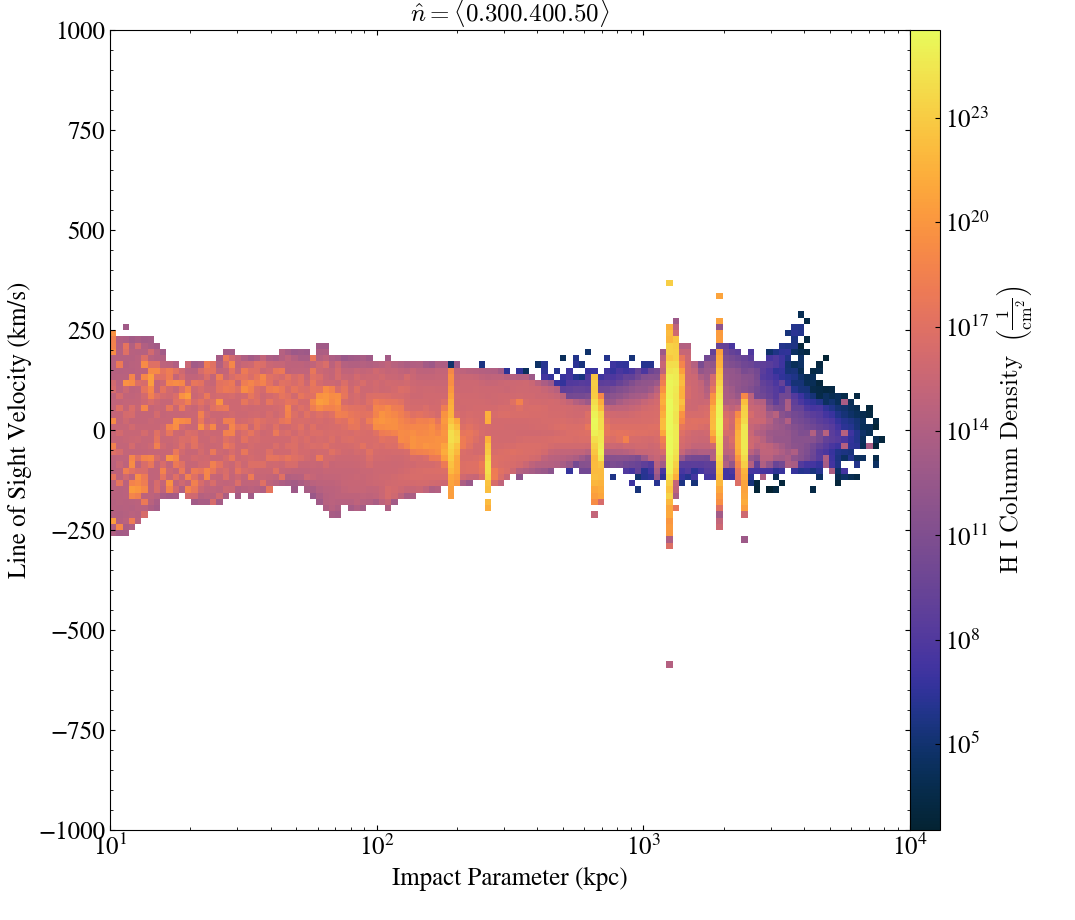

['snapshot_570_2d-Profile_cylindrical_radius_velocity_cylindrical_z_H_I_column_density.png']

In [49]:
# ax = Lnorm #[1,0,0]

# ad = ds.all_data()
# ad.set_field_parameter('center', c)
# ad.set_field_parameter('bulk_velocity', bulk_vel)
# ad.set_field_parameter('normal', np.array(ax))

# p = yt.ProjectionPlot(
#     ds, ax, fields=("gas", "density"), center=sp.center, width=(1, "Mpc")
# )
# p.set_zlim(("gas", "density"), zmin=1e-5, zmax=1e-2)
# p.show()
# p.save()

ad = ds.all_data()
ad.set_field_parameter('center', c)
ad.set_field_parameter('bulk_velocity', bulk_vel)
ad.set_field_parameter('normal', ax)

p = yt.PhasePlot(ad, ('gas', 'cylindrical_radius'), ('gas', 'velocity_cylindrical_z'), ("gas","H_I_column_density"), weight_field=None)
p.set_title(('gas', 'H_I_column_density'), f"$\hat{{n}} = \\langle {ax[0]:.2f} {ax[1]:.2f} {ax[2]:.2f} \\rangle$")
p.set_unit(('gas', 'cylindrical_radius'), 'kpc')
p.set_unit(('gas', 'velocity_cylindrical_z'), 'km/s')
p.set_log(('gas', 'velocity_cylindrical_z'), False)
p.set_xlim(1e1, 1e4)
p.set_ylim(-1000,1000)
p.set_cmap(('gas', 'H_I_column_density'), cmocean.cm.thermal)
#p.set_zlim(('gas', 'H_I_number'), 1e12, 1e25)
p.set_xlabel('Impact Parameter (kpc)')
p.set_ylabel('Line of Sight Velocity (km/s)')
p.show()
p.save()

In [30]:
p.set_title('Hello')

TypeError: set_title() missing 1 required positional argument: 'title'

In [19]:
ds.fields

In [27]:
bs = p._profile.x_bins.v
vs = p._profile.y_bins.v
btab = Table([bs], names=('b'))
vtab = Table([vs], names = ('v'))
print(btab)
print(vtab)

        b         
------------------
              10.0
 10.55449600878607
11.139738599948068
11.757432659207156
12.409377607517245
 13.09747264300595
13.823722273579051
               ...
  6853.89583865011
 7233.941627366777
 7635.060803383376
  8058.42187761485
 8505.258154439996
 8976.871324473177
  9474.63525655379
10000.000000000002
Length = 129 rows
         v         
-------------------
-1000.0000000000001
 -984.3750000000001
 -968.7500000000001
 -953.1250000000001
 -937.5000000000001
 -921.8750000000001
 -906.2500000000001
                ...
  890.6250000000001
  906.2500000000001
  921.8750000000001
  937.5000000000001
  953.1250000000001
  968.7500000000001
  984.3750000000001
 1000.0000000000001
Length = 129 rows


In [74]:
p._profile.x_bins

unyt_array([1.00000000e+01, 1.05544960e+01, 1.11397386e+01,
            1.17574327e+01, 1.24093776e+01, 1.30974726e+01,
            1.38237223e+01, 1.45902422e+01, 1.53992653e+01,
            1.62531484e+01, 1.71543790e+01, 1.81055824e+01,
            1.91095297e+01, 2.01691455e+01, 2.12875166e+01,
            2.24679009e+01, 2.37137371e+01, 2.50286543e+01,
            2.64164832e+01, 2.78812667e+01, 2.94272718e+01,
            3.10590022e+01, 3.27812115e+01, 3.45989166e+01,
            3.65174127e+01, 3.85422887e+01, 4.06794432e+01,
            4.29351021e+01, 4.53158364e+01, 4.78285814e+01,
            5.04806572e+01, 5.32797895e+01, 5.62341325e+01,
            5.93522927e+01, 6.26433537e+01, 6.61169026e+01,
            6.97830585e+01, 7.36525012e+01, 7.77365030e+01,
            8.20469611e+01, 8.65964323e+01, 9.13981699e+01,
            9.64661620e+01, 1.01815172e+02, 1.07460783e+02,
            1.13419440e+02, 1.19708503e+02, 1.26346292e+02,
            1.33352143e+02, 1.40746466e+

In [31]:
my_sphere = ds.sphere("c", (10.0, "Mpc"))
plot = yt.ProfilePlot(
    my_sphere,
    ("gas", "density"), [("gas", "temperature")]
)
plot.save()

yt : [INFO     ] 2024-06-27 00:56:54,165 Saving plot snapshot_570_1d-Profile_density_temperature.png


['snapshot_570_1d-Profile_density_temperature.png']

In [18]:
ds.derived_field_list

[('PartType0', 'C_metallicity'),
 ('PartType0', 'C_nuclei_density'),
 ('PartType0', 'C_nuclei_mass_density'),
 ('PartType0', 'Ca_metallicity'),
 ('PartType0', 'Ca_nuclei_density'),
 ('PartType0', 'Ca_nuclei_mass_density'),
 ('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'El_number_density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'Fe_metallicity'),
 ('PartType0', 'Fe_nuclei_density'),
 ('PartType0', 'Fe_nuclei_mass_density'),
 ('PartType0', 'H_nuclei_density'),
 ('PartType0', 'H_p0_density'),
 ('PartType0', 'H_p0_fraction'),
 ('PartType0', 'H_p0_mass'),
 ('PartType0', 'H_p0_number_density'),
 ('PartType0', 'H_p1_density'),
 ('PartType0', 'H_p1_fraction'),
 ('PartType0', 'H_p1_mass'),
 ('PartType0', 'H_p1_number_density'),
 ('PartType0', 'He_metallicity'),
 ('PartType0', 'He_nuclei_density'),
 ('PartType0', 'He_nuclei_mass_density'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity_00'),
 ('PartType0', 'Metalli